In [1]:
import Tasmanian as ts
import numpy as np
import scipy.optimize as opt
import sys
sys.path.append("..")
from src.py.option import AsianOption


In [2]:
def make_grid(dim, exactness, lb, rb, rule):
    """Creates a sparse grid according to given rules and boundaries.

    Args:
        dim (int): Input Dimension.
        exactness (int): Exactness of the integration.
        lb (array-like): Left boundary. Shape (dim) is recommended.
        rb (array-like): Right boundary. Shape (dim) is recommended.
        rule (str):  One of the local polynomial rules in TASMANIAN docs.
            Defaults to "localp".

    Returns:
        TasmanianSparseGrid: SparseGrid object.
    """
    grid = ts.makeGlobalGrid(
        dim, 1, exactness, "level", rule
    )
    grid.setDomainTransform(np.vstack([lb, rb]).T)
    return grid

aop = AsianOption(d=2)
# iNumInputs = 4
# iNumOutputs = 1
# grid = ts.SparseGrid()
# grid.makeLocalPolynomialGrid(iNumInputs, iNumOutputs, 4, iOrder=1, sRule="localp")


In [3]:
s_0_l=80.0
s_0_r=120.0
sigma_l=0.1
sigma_r=0.2
mu_l=0.02
mu_r=0.05
T_l=0.9
T_r=1.0

transform = np.array(
    [[s_0_l, s_0_r],
    [sigma_l, sigma_r],
    [mu_l, mu_r],
    [T_l, T_r]
    ]
)

In [52]:
dim, level = 2, 5
lb, rb =  np.zeros(dim), np.ones(dim)
grid = make_grid(dim, level, lb, rb, "gauss-patterson")
points = grid.getPoints()


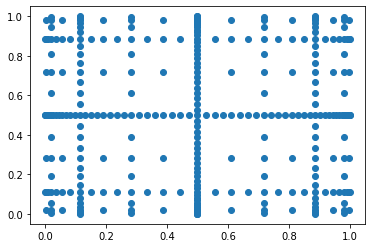

In [53]:
import matplotlib.pyplot as plt

plt.scatter(points[:, 0], points[:, 1])
plt.show()
# 3d plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# plt.show()

## Slice Arrays for smoothing

In [54]:
# ar = points[points[:, :-1].argsort(axis=0)[:, 0]]
hyperplanes, indices = np.unique(points[:, :-1], axis=0, return_index=True)

grid_slices = np.split(points, sorted(indices)[1:], axis=0)


In [55]:
# def cumargmax(a):
#     m = np.maximum.accumulate(a)
#     x = np.repeat(np.arange(a.shape[0])[:, None], a.shape[1], axis=1)
#     x[1:] *= m[:-1] < m[1:]
#     np.maximum.accumulate(x, axis=0, out=x)
#     return x[:, -1]

# partitions = np.unique(cumargmax(ar))
# grid_slices = np.split(ar, partitions[1:], axis=0)

In [56]:
# fig, axes = plt.subplots(nrows=5, ncols=4,sharex=True, sharey=True, figsize=(10,10))
# axes = np.ravel(axes)
# for i in range(len(grid_slices)):
#     x, y  = grid_slices[i][:, 0], grid_slices[i][:, 1]
#     axes[i].scatter(x,y)
# plt.show()
hyperplanes

array([[6.35559398e-05],
       [4.50937516e-04],
       [1.39687031e-03],
       [3.08401839e-03],
       [5.65762123e-03],
       [9.23442522e-03],
       [1.39085626e-02],
       [1.97543656e-02],
       [2.68285708e-02],
       [3.51725713e-02],
       [4.48144215e-02],
       [5.57703836e-02],
       [6.80460309e-02],
       [8.16370309e-02],
       [9.65297340e-02],
       [1.12701665e-01],
       [1.30121978e-01],
       [1.48751897e-01],
       [1.68545170e-01],
       [1.89448527e-01],
       [2.11402145e-01],
       [2.34340128e-01],
       [2.58190987e-01],
       [2.82878125e-01],
       [3.08320338e-01],
       [3.34432303e-01],
       [3.61125089e-01],
       [3.88306657e-01],
       [4.15882374e-01],
       [4.43755528e-01],
       [4.71827843e-01],
       [5.00000000e-01],
       [5.28172157e-01],
       [5.56244472e-01],
       [5.84117626e-01],
       [6.11693343e-01],
       [6.38874911e-01],
       [6.65567697e-01],
       [6.91679662e-01],
       [7.17121875e-01],


In [57]:
# Nullstellen findung vektorisieren!!!

def payout_coordinate_split(hyperplane, line):
    return aop.payout_func_opt(np.hstack([hyperplane, line]))

def fprime(x):
    return aop.payout_func_opt_der(x, coordinate=-1)

# roots = list()
# for plane in hyperplanes:
#     foo = lambda x: aop.payout_func_opt(np.hstack([plane, x]))
#     foo_fprime = lambda x: fprime(np.hstack([plane, x]))
#     sol = opt.root_scalar(foo, x0=0.999, fprime=foo_fprime, method='newton')
#     roots.append(sol.root)

def find_hyperplane_root(plane, method, x0=0.999):
    foo = lambda x: aop.payout_func_opt(np.hstack([plane, x]))
    foo_fprime = lambda x: fprime(np.hstack([plane, x]))
    if method == "bisect":
        sol = opt.root_scalar(foo, x0=0.999, bracket=[1, 0], method=method)
    if method == "newton":
        sol = opt.root_scalar(foo, x0=0.999, fprime=foo_fprime, method=method)
    return sol.root

ar_roots = np.apply_along_axis(find_hyperplane_root, axis=1, arr=hyperplanes, method="newton")


In [58]:
ar_roots

array([0.999     , 0.999     , 0.999     , 0.999     , 0.999     ,
       0.999     , 0.999     , 0.999     , 0.9986966 , 0.99720437,
       0.9945547 , 0.99020433, 0.9835162 , 0.97379558, 0.96033912,
       0.94249191, 0.91970668, 0.89159862, 0.85798998, 0.8189399 ,
       0.7747564 , 0.72598939, 0.6734057 , 0.61794848, 0.5606849 ,
       0.50274687, 0.44525988, 0.38913103, 0.33567689, 0.28572983,
       0.23641344, 0.17659689, 0.1191615 , 0.06516597, 0.01578671,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

In [59]:
transformed_slices = list()
for slice, zero in zip(grid_slices, ar_roots):
    if np.isnan(zero) or zero == .999:
        transformed_slices.append(slice)
    else:
        transformed_slices.append(slice*(1-zero)+zero)

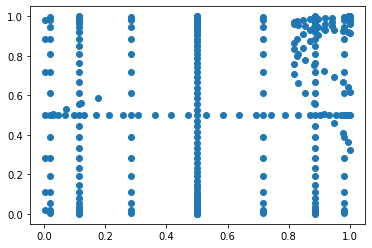

In [60]:
transformed_points = np.concatenate(transformed_slices)


plt.scatter(transformed_points[:, 0], transformed_points[:, 1])
plt.show()
# 3d plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2])
# plt.show()

In [61]:
np.inner(grid.getQuadratureWeights(), aop.payout_func_opt(points)), aop.scholes_call()

(9.914494443961734, 9.927486225229053)

In [62]:
np.inner(grid.getQuadratureWeights(), aop.payout_func_opt(transformed_points)), aop.scholes_call()

(24.48898293457935, 9.927486225229053)

In [63]:
transformed_points[-8:]

array([[0.90347027, 0.5       ],
       [0.93195397, 0.5       ],
       [0.95518558, 0.5       ],
       [0.97317143, 0.5       ],
       [0.98609144, 0.5       ],
       [0.99434238, 0.5       ],
       [0.99860313, 0.5       ],
       [0.99993644, 0.5       ]])